In [1]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, callbacks
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.16.1
GPU Available: []


In [2]:
# Cell 2: Load Data
print("Loading data...")
train_data = pd.read_csv('data_minihackathon_train.csv')
test_data = pd.read_csv('data_minihackathon_test.csv')

print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"\nTraining data info:")
print(train_data.info())
print(f"\nMissing values in training data:")
print(train_data.isnull().sum())

Loading data...
Training data shape: (1500, 14)
Test data shape: (377, 13)

Training data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             1500 non-null   int64  
 1   Age            1498 non-null   float64
 2   Gender         1499 non-null   float64
 3   Education      1480 non-null   float64
 4   Country        1498 non-null   float64
 5   Ethnicity      1500 non-null   float64
 6   Nscore         1499 non-null   float64
 7   Escore         1499 non-null   float64
 8   Oscore         1499 non-null   float64
 9   Ascore         1499 non-null   float64
 10  Cscore         1499 non-null   float64
 11  Impulsive      1499 non-null   float64
 12  SS             1500 non-null   float64
 13  drug_category  1500 non-null   object 
dtypes: float64(12), int64(1), object(1)
memory usage: 164.2+ KB
None

Missing values in trai


Target distribution:
drug_category
Hallucinogens    691
Stimulants       567
Depressants      242
Name: count, dtype: int64

Target distribution (%):
drug_category
Hallucinogens    46.066667
Stimulants       37.800000
Depressants      16.133333
Name: proportion, dtype: float64


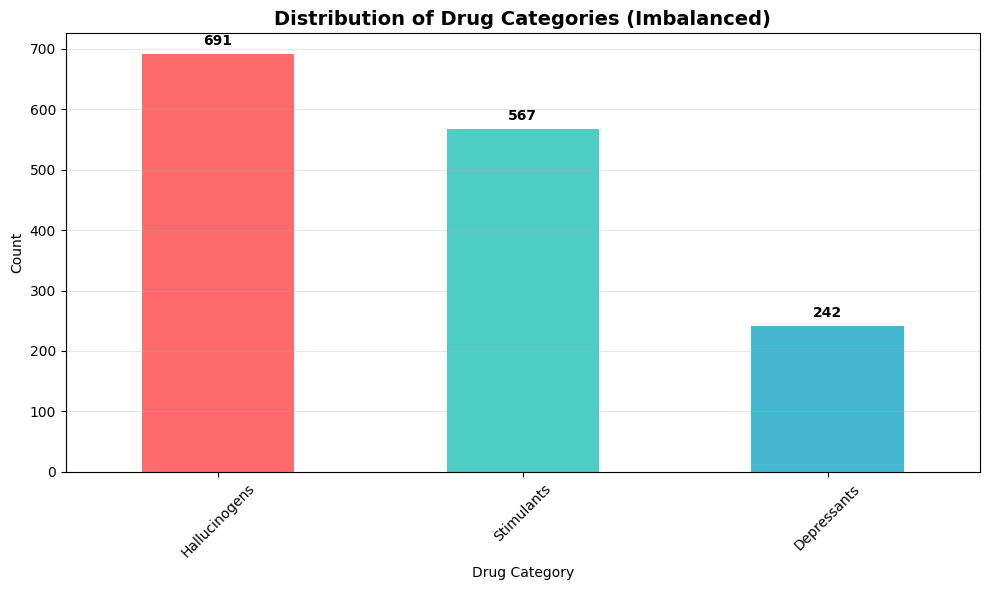

In [3]:
# Cell 3: Exploratory Data Analysis
print("\nTarget distribution:")
print(train_data['drug_category'].value_counts())
print("\nTarget distribution (%):")
print(train_data['drug_category'].value_counts(normalize=True) * 100)

# Visualize class distribution
plt.figure(figsize=(10, 6))
train_data['drug_category'].value_counts().plot(kind='bar', color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
plt.title('Distribution of Drug Categories (Imbalanced)', fontsize=14, fontweight='bold')
plt.xlabel('Drug Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
for i, v in enumerate(train_data['drug_category'].value_counts()):
    plt.text(i, v + 10, str(v), ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()


Personality Scores Statistics:
            Nscore       Escore       Oscore       Ascore       Cscore
count  1499.000000  1499.000000  1499.000000  1499.000000  1499.000000
mean      0.008824     0.020937     0.003109    -0.019381    -0.003049
std       1.003332     1.621908     0.988426     0.990944     1.031552
min      -3.464360    -3.273930    -2.859500    -3.464360   -10.000000
25%      -0.678250    -0.695090    -0.717270    -0.606330    -0.652530
50%       0.042570     0.003320    -0.019280    -0.017290    -0.006650
75%       0.629670     0.637790     0.723300     0.590420     0.758300
max       3.273930    50.000000     2.901610     3.464360     3.464360


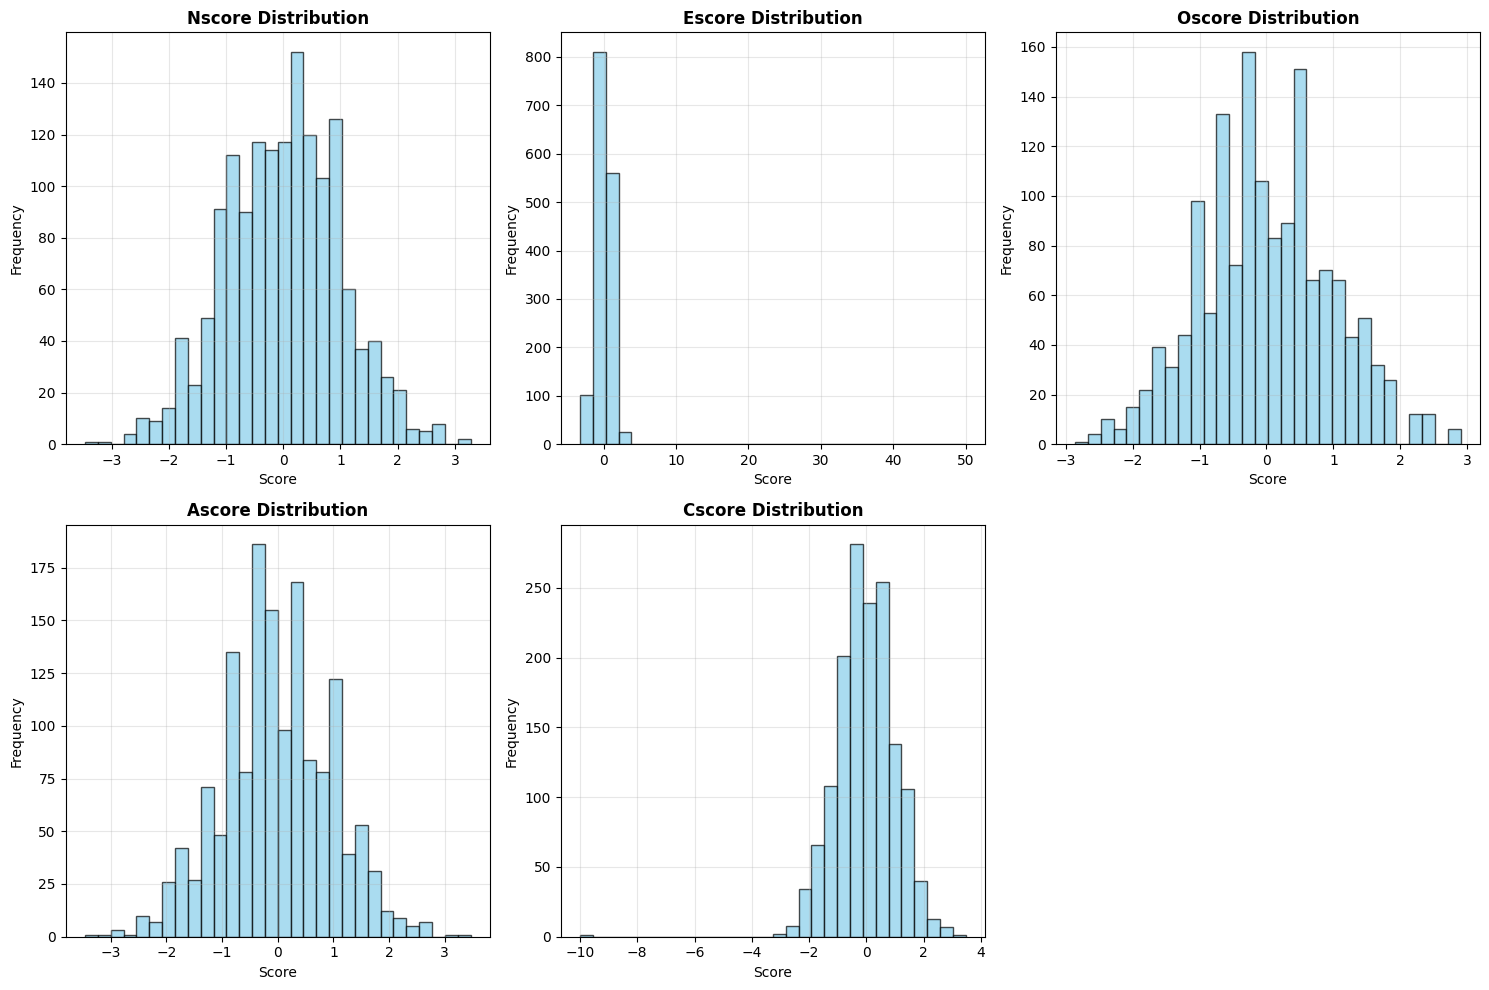

In [4]:
# Cell 4: Analyze Personality Scores Distribution
personality_cols = ['Nscore', 'Escore', 'Oscore', 'Ascore', 'Cscore']

print("\nPersonality Scores Statistics:")
print(train_data[personality_cols].describe())

# Visualize personality scores
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, col in enumerate(personality_cols):
    axes[idx].hist(train_data[col], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'{col} Distribution', fontweight='bold')
    axes[idx].set_xlabel('Score')
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(alpha=0.3)

axes[5].axis('off')
plt.tight_layout()
plt.show()

In [5]:
# Cell 5: Data Preprocessing - Separate Features and Target
X = train_data.drop(['ID', 'drug_category'], axis=1)
y = train_data['drug_category']
X_test = test_data.drop(['ID'], axis=1)
test_ids = test_data['ID']

print(f"Features shape: {X.shape}")
print(f"Features: {list(X.columns)}")

Features shape: (1500, 12)
Features: ['Age', 'Gender', 'Education', 'Country', 'Ethnicity', 'Nscore', 'Escore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS']


In [6]:
# Cell 6: Handle Missing Values
print("\nHandling missing values...")
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

print(f"Missing values after imputation: {X_imputed.isnull().sum().sum()}")


Handling missing values...
Missing values after imputation: 0


In [7]:
# Cell 7: Feature Engineering - Create Interaction Features
print("\nCreating interaction features...")

# Create polynomial and interaction features for personality scores
personality_cols = ['Nscore', 'Escore', 'Oscore', 'Ascore', 'Cscore']

# Add squared terms
for col in personality_cols:
    X_imputed[f'{col}_squared'] = X_imputed[col] ** 2
    X_test_imputed[f'{col}_squared'] = X_test_imputed[col] ** 2

# Add interaction terms
X_imputed['personality_sum'] = X_imputed[personality_cols].sum(axis=1)
X_test_imputed['personality_sum'] = X_test_imputed[personality_cols].sum(axis=1)

X_imputed['personality_mean'] = X_imputed[personality_cols].mean(axis=1)
X_test_imputed['personality_mean'] = X_test_imputed[personality_cols].mean(axis=1)

X_imputed['personality_std'] = X_imputed[personality_cols].std(axis=1)
X_test_imputed['personality_std'] = X_test_imputed[personality_cols].std(axis=1)

# Impulsive interactions
X_imputed['impulsive_x_nscore'] = X_imputed['Impulsive'] * X_imputed['Nscore']
X_test_imputed['impulsive_x_nscore'] = X_test_imputed['Impulsive'] * X_test_imputed['Nscore']

print(f"Enhanced features shape: {X_imputed.shape}")


Creating interaction features...
Enhanced features shape: (1500, 21)


In [8]:
# Cell 8: Encode Target Variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)

print(f"Number of classes: {num_classes}")
print(f"Classes: {label_encoder.classes_}")
print(f"Encoding mapping:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"  {class_name} -> {i}")

Number of classes: 3
Classes: ['Depressants' 'Hallucinogens' 'Stimulants']
Encoding mapping:
  Depressants -> 0
  Hallucinogens -> 1
  Stimulants -> 2


In [9]:
# Cell 9: Train-Validation Split (Stratified)
X_train, X_val, y_train, y_val = train_test_split(
    X_imputed, y_encoded, 
    test_size=0.15,  # Slightly larger validation set
    random_state=42, 
    stratify=y_encoded  # Maintain class distribution
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"\nTraining set class distribution:")
print(pd.Series(y_train).value_counts().sort_index())
print(f"\nValidation set class distribution:")
print(pd.Series(y_val).value_counts().sort_index())

Training set size: 1275
Validation set size: 225

Training set class distribution:
0    206
1    587
2    482
Name: count, dtype: int64

Validation set class distribution:
0     36
1    104
2     85
Name: count, dtype: int64


In [10]:
# Cell 10: Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test_imputed)

print(f"Scaled training data shape: {X_train_scaled.shape}")
print(f"Feature mean after scaling: {X_train_scaled.mean():.6f}")
print(f"Feature std after scaling: {X_train_scaled.std():.6f}")

Scaled training data shape: (1275, 21)
Feature mean after scaling: 0.000000
Feature std after scaling: 1.000000



HANDLING CLASS IMBALANCE

Before SMOTE:
0    206
1    587
2    482
Name: count, dtype: int64

After SMOTE + Tomek:
0    579
1    560
2    564
Name: count, dtype: int64

New training set size: 1703


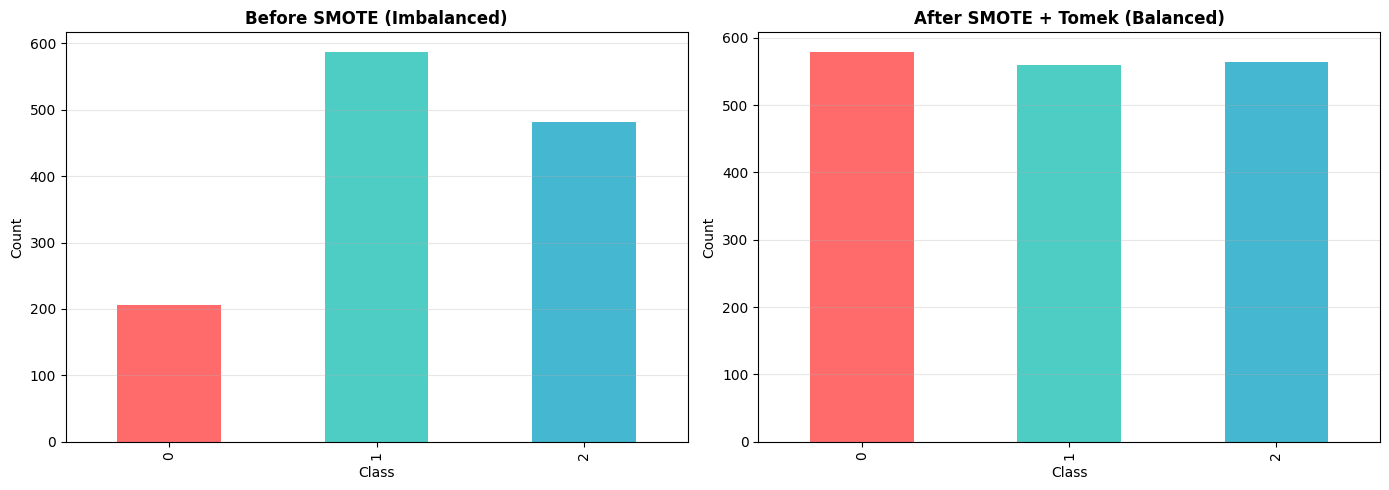

In [11]:
# Cell 11: Handle Class Imbalance with SMOTE + Tomek Links
print("\n" + "="*60)
print("HANDLING CLASS IMBALANCE")
print("="*60)

print("\nBefore SMOTE:")
print(pd.Series(y_train).value_counts().sort_index())

# Apply SMOTE with Tomek links (combines oversampling and undersampling)
smote_tomek = SMOTETomek(random_state=42)
X_train_balanced, y_train_balanced = smote_tomek.fit_resample(X_train_scaled, y_train)

print("\nAfter SMOTE + Tomek:")
print(pd.Series(y_train_balanced).value_counts().sort_index())
print(f"\nNew training set size: {X_train_balanced.shape[0]}")

# Visualize before and after
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before
pd.Series(y_train).value_counts().sort_index().plot(kind='bar', ax=axes[0], 
                                                      color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[0].set_title('Before SMOTE (Imbalanced)', fontweight='bold', fontsize=12)
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].grid(axis='y', alpha=0.3)

# After
pd.Series(y_train_balanced).value_counts().sort_index().plot(kind='bar', ax=axes[1],
                                                               color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[1].set_title('After SMOTE + Tomek (Balanced)', fontweight='bold', fontsize=12)
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:
# Cell 12: Calculate Class Weights (Additional Safety)
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

print("\nClass Weights:")
for class_idx, weight in class_weight_dict.items():
    class_name = label_encoder.classes_[class_idx]
    print(f"  {class_name} (Class {class_idx}): {weight:.4f}")


Class Weights:
  Depressants (Class 0): 2.0631
  Hallucinogens (Class 1): 0.7240
  Stimulants (Class 2): 0.8817


In [13]:
# Cell 13: Build Improved Model Architecture
def create_improved_model(input_dim, num_classes, learning_rate=0.0005):
    model = models.Sequential([
        # Input layer with higher capacity
        layers.Dense(256, activation='relu', 
                    kernel_regularizer=keras.regularizers.l2(0.001),
                    input_shape=(input_dim,)),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        
        # Second hidden layer
        layers.Dense(512, activation='relu',
                    kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        # Third hidden layer
        layers.Dense(256, activation='relu',
                    kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        
        # Fourth hidden layer
        layers.Dense(128, activation='relu',
                    kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        # Fifth hidden layer
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])
    
    # Use AdamW optimizer with weight decay
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate,
        weight_decay=1e-5
    )
    
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create model
input_dim = X_train_balanced.shape[1]
model = create_improved_model(input_dim, num_classes, learning_rate=0.0005)

# Display model architecture
print("\nModel Architecture:")
model.summary()


Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         5,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 314,755 (1.20 MB)

 Trainable params: 312,323 (1.19 MB)

 Non-trainable params: 2,432 (9.50 KB)

In [14]:
# Cell 14: Setup Callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=40,  # Increased patience
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=15,  # Increased patience
    min_lr=1e-7,
    verbose=1
)

checkpoint = callbacks.ModelCheckpoint(
    'best_model_balanced.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

callback_list = [early_stopping, reduce_lr, checkpoint]

In [15]:
# Cell 15: Train Model with Balanced Data and Class Weights
print("\n" + "="*60)
print("TRAINING NEURAL NETWORK ON BALANCED DATA")
print("="*60)

history = model.fit(
    X_train_balanced, y_train_balanced,
    validation_data=(X_val_scaled, y_val),
    epochs=200,  # More epochs
    batch_size=16,  # Smaller batch size for better generalization
    class_weight=class_weight_dict,  # Apply class weights
    callbacks=callback_list,
    verbose=1
)

print("\n✓ Training completed!")


TRAINING NEURAL NETWORK ON BALANCED DATA
Epoch 1/200
 96/107 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3903 - loss: 2.6743
Epoch 1: val_accuracy improved from -inf to 0.16444, saving model to best_model_balanced.keras
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.3928 - loss: 2.6622 - val_accuracy: 0.1644 - val_loss: 2.3867 - learning_rate: 5.0000e-04
Epoch 2/200
102/107 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4946 - loss: 2.3215
Epoch 2: val_accuracy improved from 0.16444 to 0.19556, saving model to best_model_balanced.keras
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4947 - loss: 2.3216 - val_accuracy: 0.1956 - val_loss: 2.9658 - learning_rate: 5.0000e-04
Epoch 3/200
101/107 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4675 - loss: 2.2065
Epoch 3: val_accuracy improved from 0.19556 to 0.22667, saving model to best_model_balanced.keras
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4687 - loss: 2.2058 - val_accuracy: 0.2267 - val_loss: 3.1290

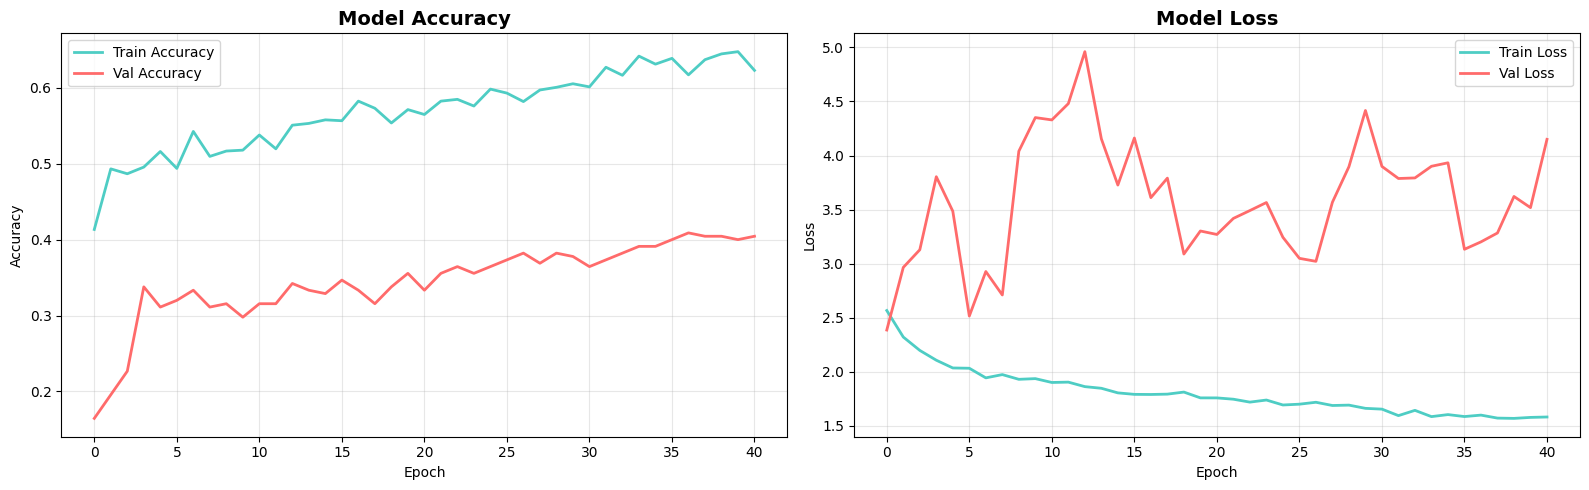

In [16]:
# Cell 16: Plot Training History
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot accuracy
axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2, color='#4ECDC4')
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2, color='#FF6B6B')
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot loss
axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2, color='#4ECDC4')
axes[1].plot(history.history['val_loss'], label='Val Loss', linewidth=2, color='#FF6B6B')
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [17]:
# Cell 17: Evaluate Model
# Load best model
model = keras.models.load_model('best_model_balanced.keras')

# Predictions on validation set
y_val_pred_probs = model.predict(X_val_scaled)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)

# Calculate accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"\n{'='*60}")
print(f"VALIDATION ACCURACY: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
print(f"{'='*60}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

VALIDATION ACCURACY: 0.4089 (40.89%)


In [18]:
# Cell 18: Classification Report
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(
    y_val, y_val_pred,
    target_names=label_encoder.classes_,
    digits=4
))


CLASSIFICATION REPORT
               precision    recall  f1-score   support

  Depressants     0.1840    0.6389    0.2857        36
Hallucinogens     0.7400    0.3558    0.4805       104
   Stimulants     0.6400    0.3765    0.4741        85

     accuracy                         0.4089       225
    macro avg     0.5213    0.4570    0.4134       225
 weighted avg     0.6133    0.4089    0.4469       225



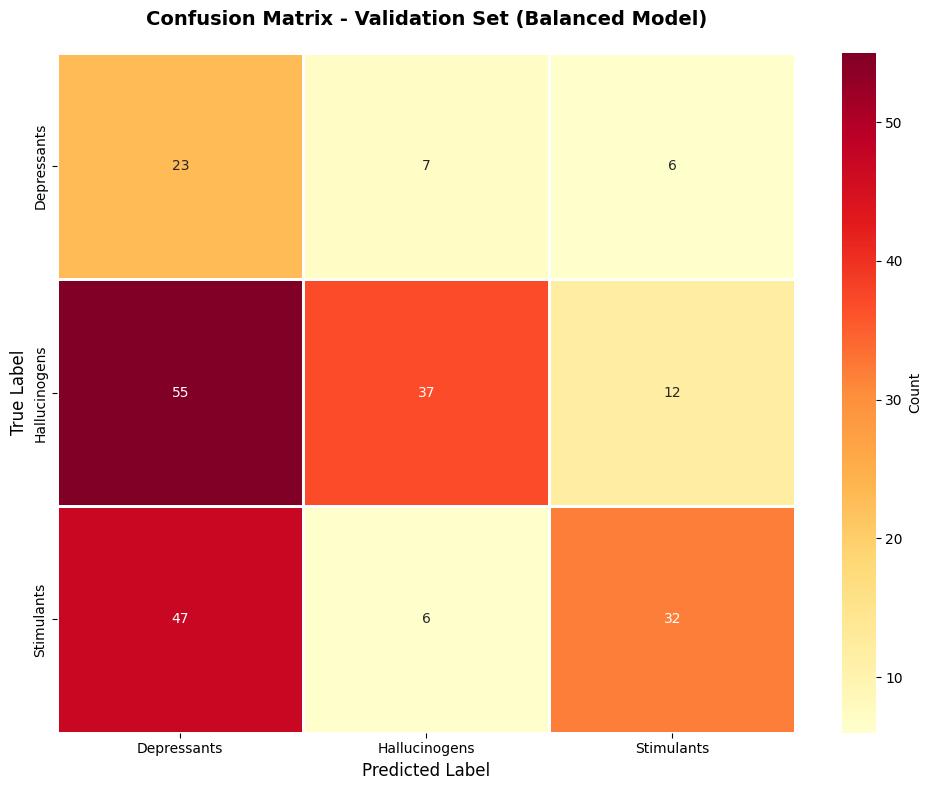

In [19]:
# Cell 19: Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='YlOrRd',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    cbar_kws={'label': 'Count'},
    linewidths=1,
    linecolor='white'
)
plt.title('Confusion Matrix - Validation Set (Balanced Model)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
# Cell 1: Import Libraries
import pandas as pd

# Cell 2: Load the predictions.csv file
predictions_df = pd.read_csv('improved_submission.csv')

# Cell 3: Adjust the ID column by subtracting 1000
predictions_df['ID'] = predictions_df['ID'] - 1000

# Cell 4: Verify the new ID range
print("New ID range:")
print(f"Min ID: {predictions_df['ID'].min()}")
print(f"Max ID: {predictions_df['ID'].max()}")

# Cell 5: Save the updated DataFrame to a new CSV file
predictions_df.to_csv('predictions_updated3.csv', index=False)
print("✓ Updated predictions saved to 'improved_submission_updated.csv'")

New ID range:
Min ID: 501
Max ID: 877
✓ Updated predictions saved to 'predictions_updated.csv'
